In [1]:
#One-time: load annotation table + rename peak column

import pandas as pd

ANN = "/datasets/renew_kirkeby/jonas/Data/Mistr_atac/251120_VH01386_221_222GHHTNX_data/PIPELINE-nfcore-atacseq/GRCh38_ensembl/bowtie2/merged_replicate/macs2/narrow_peak/consensus/consensus_peaks.mRp.clN.annotatePeaks.txt"

ann = pd.read_csv(ANN, sep="\t", comment="#")
peak_col = ann.columns[0]
ann2 = ann.rename(columns={peak_col: "peak_id"}).copy()

print("Loaded ann2:", ann2.shape)
print("Example gene columns:", [c for c in ann2.columns if "Gene" in c][:6])

Loaded ann2: (339784, 19)
Example gene columns: ['Gene Name', 'Gene Alias', 'Gene Description', 'Gene Type']


In [2]:
# Function: find promoter-prox peaks for ANY gene

def get_promoter_prox_peaks(ann2, gene, tss_window=10000):
    """
    Return promoter-proximal peaks (within ±tss_window of TSS) for a given gene.

    ann2: HOMER annotatePeaks table with columns:
          'Gene Name', 'Distance to TSS', 'Chr', 'Start', 'End', 'Annotation', 'peak_id'
    gene: string (e.g. "OTX2")
    tss_window: int bp (default 2000)
    """
    sub = ann2[ann2["Gene Name"].astype(str) == str(gene)].copy()
    if sub.empty:
        raise ValueError(f"No rows found for gene='{gene}' in ann2['Gene Name'].")

    # promoter-prox filter
    sub = sub[sub["Distance to TSS"].abs() <= tss_window].copy()
    if sub.empty:
        raise ValueError(f"No promoter-prox peaks found for {gene} within ±{tss_window} bp of TSS.")

    # sort by closeness to TSS
    sub["abs_dist"] = sub["Distance to TSS"].abs()
    sub = sub.sort_values(["abs_dist", "Start"]).copy()

    return sub[["peak_id","Chr","Start","End","Distance to TSS","Annotation","abs_dist"]]
   
   
get_promoter_prox_peaks(ann2, "OTX2", tss_window=2000).head(10)

,peak_id,Chr,Start,End,Distance to TSS,Annotation,abs_dist
239641,Interval_92891,14,56808263,56809549,1316.0,"intron (ENSG00000165588, intron 1 of 4)",1316.0
42614,Interval_92892,14,56810446,56812920,-1461.0,"intron (ENSG00000165588, intron 1 of 4)",1461.0


In [3]:
BW_DIR = "/datasets/renew_kirkeby/jonas/Data/Mistr_atac/251120_VH01386_221_222GHHTNX_data/PIPELINE-nfcore-atacseq/GRCh38_ensembl/bowtie2/merged_replicate/bigwig"

DEFAULT_TRACKS = {
    "0h":  {"PSC": "H9_0h_undiff.mRp.clN.bigWig"},
    "12h": {"FB":  "H9_12h_FB.mRp.clN.bigWig",
            "HB":  "H9_12h_HB.mRp.clN.bigWig"},
    "24h": {"FB":  "H9_24h_FB.mRp.clN.bigWig",
            "HB":  "H9_24h_HB.mRp.clN.bigWig"},
    "48h": {"FB":  "H9_48h_FB.mRp.clN.bigWig",
            "HB":  "H9_48h_HB.mRp.clN.bigWig"},
    "3d":  {"FB":  "H9_3d_FB.mRp.clN.bigWig",
            "HB":  "H9_3d_HB.mRp.clN.bigWig"},
    "5d":  {"FB":  "H9_5d_FB.mRp.clN.bigWig",
            "HB":  "H9_5d_HB.mRp.clN.bigWig"},
}

In [ ]:
BW_DIR = "/datasets/renew_kirkeby/jonas/Data/Mistr_atac/251120_VH01386_221_222GHHTNX_data/PIPELINE-nfcore-atacseq/GRCh38_ensembl/bowtie2/merged_replicate/bigwig"

DEFAULT_TRACKS = {

    "48h": {"FB":  "KOLF_48h_FB.mRp.clN.bigWig",
            "HB":  "KOLF_48h_HB.mRp.clN.bigWig"},

}

# plot both the peaks in one

In [4]:
import os
import numpy as np
import pandas as pd
import pyBigWig
import matplotlib.pyplot as plt


def plot_gene_timecourse_tracks_multipeaks(
    ann2: pd.DataFrame,
    gene: str,
    tss_window: int = 2000,
    flank: int = 10_000,
    bins: int = 500,
    which_peaks="all",     # "all" | "closest_n" | list[int] | list[str peak_id]
    closest_n: int = 2,    # used if which_peaks=="closest_n"
    tracks=None,           # dict like DEFAULT_TRACKS
    bw_dir=None,           # bigwig directory
    peak_alpha: float = 0.18,
    show_peak_labels: bool = True,
    # ---- NEW: saving ----
    save: bool = False,
    outdir: str = ".",
    prefix: str | None = None,
    fmt: str = "png",      # "png" or "pdf" etc.
    dpi: int = 300,
    bbox_inches: str = "tight",
):
    """
    Plot bigWig tracks over time for a gene, highlighting MULTIPLE promoter-prox peaks.

    New:
      - If save=True, writes figure to:
        {outdir}/{prefix or gene}_tracks_{which_peaks}.{fmt}
      - Returns (peaks_all, peaks_used, fig, outpath)
    """

    # ---- defaults ----
    if tracks is None:
        tracks = DEFAULT_TRACKS
    if bw_dir is None:
        bw_dir = BW_DIR

    # ---- 1) promoter-prox peaks ----
    peaks_all = get_promoter_prox_peaks(ann2, gene, tss_window=tss_window).copy()
    if peaks_all.empty:
        raise ValueError(f"No promoter-prox peaks found for {gene} within ±{tss_window} bp.")

    # ---- 2) choose which peaks ----
    if which_peaks == "all":
        peaks_used = peaks_all.copy()

    elif which_peaks == "closest_n":
        peaks_used = peaks_all.head(int(closest_n)).copy()

    elif isinstance(which_peaks, (list, tuple)) and len(which_peaks) > 0:
        # list of indices OR list of peak_ids
        if all(isinstance(x, int) for x in which_peaks):
            idx = list(which_peaks)
            bad = [i for i in idx if i < 0 or i >= len(peaks_all)]
            if bad:
                raise IndexError(f"Peak indices out of range: {bad}. Available: 0..{len(peaks_all)-1}")
            peaks_used = peaks_all.iloc[idx].copy()
        else:
            wanted = set(str(x) for x in which_peaks)
            peaks_used = peaks_all[peaks_all["peak_id"].astype(str).isin(wanted)].copy()
            if peaks_used.empty:
                raise ValueError(f"None of the requested peak_ids found for {gene}: {which_peaks}")
    else:
        raise ValueError("which_peaks must be one of: 'all', 'closest_n', list[int], list[str peak_id]")

    # ---- 3) locus window (spans ALL chosen peaks) ----
    chroms = peaks_used["Chr"].astype(str).unique()
    if len(chroms) != 1:
        raise ValueError(f"Selected peaks span multiple chromosomes: {chroms}. Choose a subset.")
    chrom = chroms[0]  # bigWigs here use '11','14','X' (no 'chr')

    left = int(peaks_used["Start"].min())
    right = int(peaks_used["End"].max())

    start = max(0, left - flank)
    end = right + flank

    # ---- bigWig reader ----
    def get_signal(path):
        path = str(path)
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        bw = pyBigWig.open(path)
        vals = bw.stats(chrom, start, end, nBins=bins, type="mean")
        bw.close()
        return np.nan_to_num(np.array(vals, dtype=float))

    x = np.linspace(start, end, bins)

    # ---- color per peak (matplotlib default cycle) ----
    peak_ids = peaks_used["peak_id"].astype(str).tolist()
    peak_colors = {pid: f"C{i % 10}" for i, pid in enumerate(peak_ids)}

    # ---- helper text for title ----
    peaks_txt = ", ".join(
       [f"{r['peak_id']}({int(r['Distance to TSS'])}bp)" for _, r in peaks_used.iterrows()]
    )

    # ---- 4) plot ----
    n = len(tracks)
    fig, axes = plt.subplots(n, 1, figsize=(10, 1.9 * n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, (tp, ds) in zip(axes, tracks.items()):
        # plot tracks
        for label, fname in ds.items():
            bw_path = os.path.join(bw_dir, fname)
            y = get_signal(bw_path)
            ax.plot(x, y, linewidth=2, label=label)

        # shade peaks
        ymax = ax.get_ylim()[1]
        for _, r in peaks_used.iterrows():
            pid = str(r["peak_id"])
            ps = int(r["Start"])
            pe = int(r["End"])
            ax.axvspan(ps, pe, alpha=peak_alpha, color=peak_colors[pid])

            if show_peak_labels:
                mid = (ps + pe) / 2
                ax.text(mid, ymax, pid, fontsize=8, ha="center", va="top", rotation=90)

        ax.set_title(f"{gene} locus — {tp}  | peaks: {peaks_txt}", fontsize=11)
        ax.set_ylabel("bigWig")
        ax.legend(frameon=False, ncol=3, loc="upper right")
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(True)

    axes[-1].set_xlabel(f"{chrom}:{start:,}-{end:,}")
    plt.tight_layout()

    outpath = None
    if save:
        os.makedirs(outdir, exist_ok=True)

        safe_gene = "".join([c if c.isalnum() or c in "._-" else "_" for c in str(gene)])
        if prefix is None:
            prefix = safe_gene

        # encode which peaks in filename (short + readable)
        if which_peaks == "all":
            tag = "all"
        elif which_peaks == "closest_n":
            tag = f"closest{closest_n}"
        elif isinstance(which_peaks, (list, tuple)):
            if all(isinstance(x, int) for x in which_peaks):
                tag = "idx" + "_".join(map(str, which_peaks))
            else:
                tag = "peaks" + "_".join([str(x) for x in which_peaks[:3]])
                if len(which_peaks) > 3:
                    tag += f"_plus{len(which_peaks)-3}"
        else:
            tag = "custom"

        outpath = os.path.join(outdir, f"{prefix}_tracks_{tag}.{fmt}")
        fig.savefig(outpath, dpi=dpi, bbox_inches=bbox_inches)
        print("Saved:", outpath)

    plt.show()

    return peaks_all, peaks_used, fig, outpath


# ---- example usage ----
# peaks_all, peaks_used, fig, outpath = plot_gene_timecourse_tracks_multipeaks(
#     ann2, "KCNQ3", which_peaks="all",
#     save=True, outdir="/home/kgr851/BULK_RNA/tracks", fmt="png", dpi=300
# )

In [5]:
# # ---- example usage ----
# peaks_all, peaks_used, fig, outpath = plot_gene_timecourse_tracks_multipeaks(
#     ann2, "KCNQ3", which_peaks="all",
#     save=True, outdir="/home/kgr851/BULK_ATAC/tracks", fmt="png", dpi=300
# )

In [6]:
# # 1) Show ALL promoter-prox peaks for PAX6 (likely 2)
# peaks_all, peaks_used = plot_gene_timecourse_tracks_multipeaks(ann2, "KCNQ3", which_peaks="all")

# # # 2) Show only the two closest-to-TSS peaks (handy if a gene has many)
# # peaks_all, peaks_used = plot_gene_timecourse_tracks_multipeaks(ann2, "PAX6", which_peaks="closest_n", closest_n=2)

# # # 3) Explicitly choose peaks by index after sorting (0-based)
# #peaks_all, peaks_used = plot_gene_timecourse_tracks_multipeaks(ann2, "PAX6", which_peaks=[ 1])

# # # 4) Explicitly choose by peak_id (most reproducible)
# # peaks_all, peaks_used = plot_gene_timecourse_tracks_multipeaks(
# #     ann2, "PAX6", which_peaks=["Interval_50538", "Interval_50537"]
# # )

In [7]:
from pathlib import Path

def batch_plot_gene_tracks(
    ann2,
    genes,
    outdir,
    which_peaks="all",
    tss_window=10000,
    flank=10_000,
    bins=500,
    dpi=300,
    fmt="png",
):
    """
    Loop plot_gene_timecourse_tracks_multipeaks over multiple genes.

    Returns
    -------
    results : dict
        gene -> dict with peaks_all, peaks_used, outpath
    failed : dict
        gene -> error message
    """
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    results = {}
    failed = {}

    for gene in genes:
        print(f"\n▶ Plotting {gene} ...")
        try:
            peaks_all, peaks_used, fig, outpath = plot_gene_timecourse_tracks_multipeaks(
                ann2=ann2,
                gene=gene,
                which_peaks=which_peaks,
                tss_window=tss_window,
                flank=flank,
                bins=bins,
                save=True,
                outdir=str(outdir),
                fmt=fmt,
                dpi=dpi,
            )

            results[gene] = {
                "peaks_all": peaks_all,
                "peaks_used": peaks_used,
                "outpath": outpath,
            }
            plt.show()
            plt.close(fig)

        except Exception as e:
            failed[gene] = str(e)
            print(f"  ✗ Failed for {gene}: {e}")

    print("\n✅ Finished")
    print(f"  Successful: {len(results)}")
    print(f"  Failed: {len(failed)}")

    return results, failed

In [8]:
# genes = [
#     "KCNQ3","ROR2","TAL2","DLK1","OLIG3","FEZF1","ZNF366","POU5F1","NANOG",
#     "OTX2","GBX2","HESX1","SHISA2","FEZF1","LHX5","DLK1","PAX6","FST","HOXA1",
#     "CRABP2","CYP26A1","HOXA2","SOX1","KCNQ3","TAL2","ROR2","SP5","BMP2","LMO1","SORBS2","MEIS2","PKDCC","SEZ6"
# ]


# results, failed = batch_plot_gene_tracks(
#     ann2=ann2,
#     genes=genes,
#     outdir="/home/kgr851/BULK_ATAC/tracks",
#     which_peaks="all",
#     dpi=300,
#     fmt="png",
# )



## Simplified plots: FB (green) and HB (red), no peak coloring or labels

In [16]:
def plot_gene_timecourse_tracks_simple(
    ann2: pd.DataFrame,
    gene: str,
    tss_window: int = 2000,
    flank: int = 10_000,
    bins: int = 500,
    which_peaks="all",
    closest_n: int = 2,
    tracks=None,
    bw_dir=None,
    peak_alpha: float = 0.18,
    save: bool = False,
    outdir: str = ".",
    prefix: str | None = None,
    fmt: str = "png",
    dpi: int = 300,
    bbox_inches: str = "tight",
):
    """
    Simplified version: 
    - No peak coloring (plain gray background for all peaks)
    - No peak labels
    - Track colors: FB=green, HB=red, PSC=black
    """

    if tracks is None:
        tracks = DEFAULT_TRACKS
    if bw_dir is None:
        bw_dir = BW_DIR

    # ---- promoter-prox peaks ----
    peaks_all = get_promoter_prox_peaks(ann2, gene, tss_window=tss_window).copy()
    if peaks_all.empty:
        raise ValueError(f"No promoter-prox peaks found for {gene} within ±{tss_window} bp.")

    # ---- choose which peaks ----
    if which_peaks == "all":
        peaks_used = peaks_all.copy()
    elif which_peaks == "closest_n":
        peaks_used = peaks_all.head(int(closest_n)).copy()
    elif isinstance(which_peaks, (list, tuple)) and len(which_peaks) > 0:
        if all(isinstance(x, int) for x in which_peaks):
            idx = list(which_peaks)
            bad = [i for i in idx if i < 0 or i >= len(peaks_all)]
            if bad:
                raise IndexError(f"Peak indices out of range: {bad}. Available: 0..{len(peaks_all)-1}")
            peaks_used = peaks_all.iloc[idx].copy()
        else:
            wanted = set(str(x) for x in which_peaks)
            peaks_used = peaks_all[peaks_all["peak_id"].astype(str).isin(wanted)].copy()
            if peaks_used.empty:
                raise ValueError(f"None of the requested peak_ids found for {gene}: {which_peaks}")
    else:
        raise ValueError("which_peaks must be one of: 'all', 'closest_n', list[int], list[str peak_id]")

    # ---- locus window ----
    chroms = peaks_used["Chr"].astype(str).unique()
    if len(chroms) != 1:
        raise ValueError(f"Selected peaks span multiple chromosomes: {chroms}. Choose a subset.")
    chrom = chroms[0]

    left = int(peaks_used["Start"].min())
    right = int(peaks_used["End"].max())
    start = max(0, left - flank)
    end = right + flank

    # ---- bigWig reader ----
    def get_signal(path):
        path = str(path)
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        bw = pyBigWig.open(path)
        vals = bw.stats(chrom, start, end, nBins=bins, type="mean")
        bw.close()
        return np.nan_to_num(np.array(vals, dtype=float))

    x = np.linspace(start, end, bins)

    # ---- Color map by cell type ----
    color_map = {
        "FB": "#2ecc71",   # green
        "HB": "#e74c3c",   # red
        "PSC": "#000000",  # black
    }

    # ---- 4) plot ----
    n = len(tracks)
    fig, axes = plt.subplots(n, 1, figsize=(10, 1.9 * n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, (tp, ds) in zip(axes, tracks.items()):
        # plot tracks with cell-type colors
        for label, fname in ds.items():
            bw_path = os.path.join(bw_dir, fname)
            y = get_signal(bw_path)
            color = color_map.get(label, "black")
            ax.plot(x, y, linewidth=2, label=label, color=color)

        # # shade peaks (plain gray, no coloring)
        # for _, r in peaks_used.iterrows():
        #     ps = int(r["Start"])
        #     pe = int(r["End"])
        #     ax.axvspan(ps, pe, alpha=peak_alpha, color="gray")

        ax.set_title(f"{gene} locus — {tp}", fontsize=11)
        ax.set_ylabel("bigWig")
        ax.legend(frameon=False, ncol=3, loc="upper right")
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(True)

    axes[-1].set_xlabel(f"{chrom}:{start:,}-{end:,}")
    plt.tight_layout()

    outpath = None
    if save:
        os.makedirs(outdir, exist_ok=True)
        safe_gene = "".join([c if c.isalnum() or c in "._-" else "_" for c in str(gene)])
        if prefix is None:
            prefix = safe_gene

        if which_peaks == "all":
            tag = "all_simple"
        elif which_peaks == "closest_n":
            tag = f"closest{closest_n}_simple"
        elif isinstance(which_peaks, (list, tuple)):
            if all(isinstance(x, int) for x in which_peaks):
                tag = "idx" + "_".join(map(str, which_peaks)) + "_simple"
            else:
                tag = "peaks" + "_".join([str(x) for x in which_peaks[:3]])
                if len(which_peaks) > 3:
                    tag += f"_plus{len(which_peaks)-3}"
                tag += "_simple"
        else:
            tag = "custom_simple"

        outpath = os.path.join(outdir, f"{prefix}_tracks_{tag}.{fmt}")
        fig.savefig(outpath, dpi=dpi, bbox_inches=bbox_inches)
        print("Saved:", outpath)

    plt.show()

    return peaks_all, peaks_used, fig, outpath


In [18]:
def batch_plot_gene_tracks_simple(
    ann2,
    genes,
    outdir,
    which_peaks="all",
    tss_window=10000,
    flank=10_000,
    bins=500,
    dpi=300,
    fmt="png",
):
    """
    Batch version of simplified plots (FB green, HB red, no peak labels).
    
    Returns
    -------
    results : dict
        gene -> dict with peaks_all, peaks_used, outpath
    failed : dict
        gene -> error message
    """
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    results = {}
    failed = {}

    for gene in genes:
        print(f"\n▶ Plotting {gene} ...")
        try:
            peaks_all, peaks_used, fig, outpath = plot_gene_timecourse_tracks_simple(
                ann2=ann2,
                gene=gene,
                which_peaks=which_peaks,
                tss_window=tss_window,
                flank=flank,
                bins=bins,
                save=True,
                outdir=str(outdir),
                fmt=fmt,
                dpi=dpi,
            )

            results[gene] = {
                "peaks_all": peaks_all,
                "peaks_used": peaks_used,
                "outpath": outpath,
            }
            plt.close(fig)

        except Exception as e:
            failed[gene] = str(e)
            print(f"  ✗ Failed for {gene}: {e}")

    print("\n✅ Finished")
    print(f"  Successful: {len(results)}")
    print(f"  Failed: {len(failed)}")

    return results, failed


Saved: /home/kgr851/BULK_ATAC/tracks/KCNQ3_tracks_all_simple.png


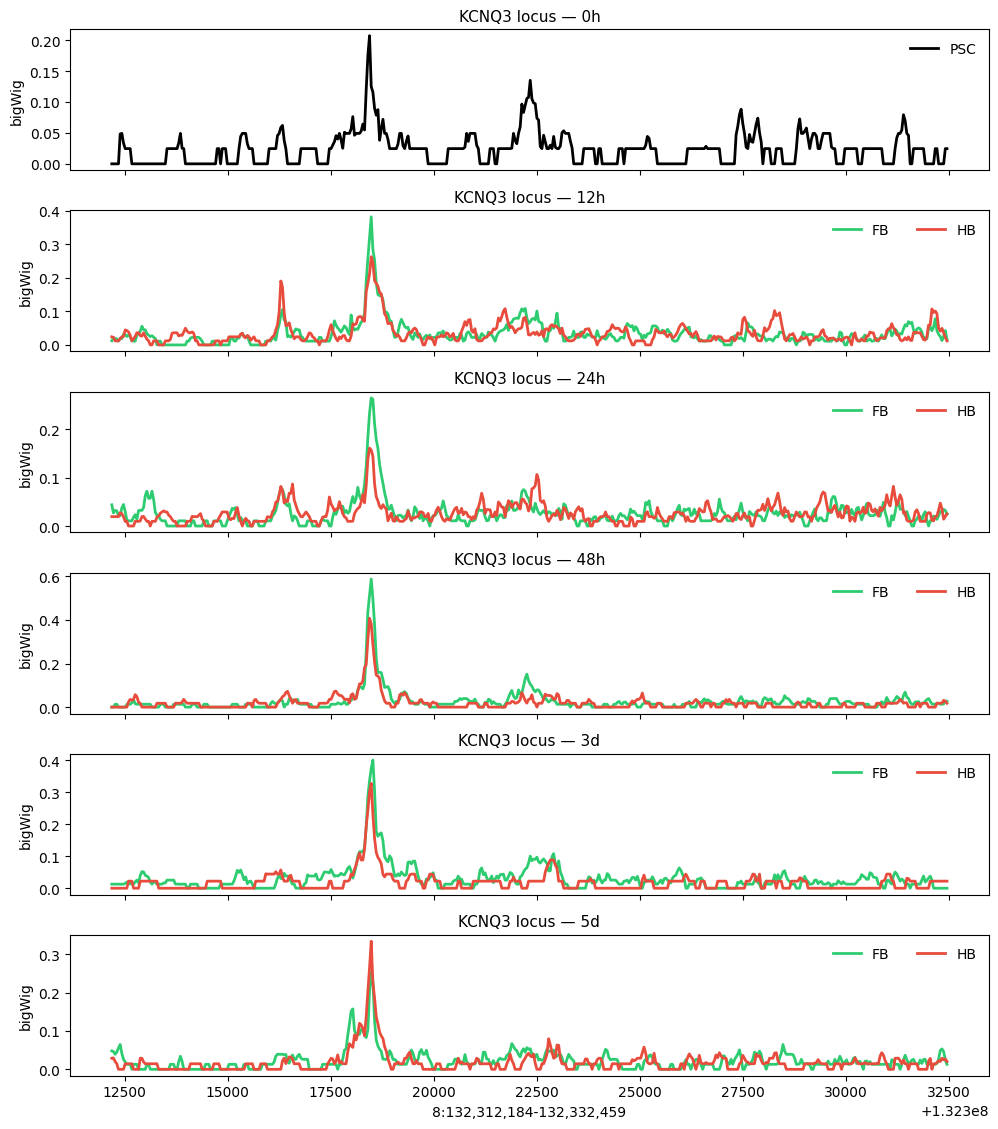

In [19]:
# Example usage: plot single gene with simplified style
peaks_all, peaks_used, fig, outpath = plot_gene_timecourse_tracks_simple(
    ann2, "KCNQ3", which_peaks="all",
    save=True, outdir="/home/kgr851/BULK_ATAC/tracks", fmt="png", dpi=300
)


In [21]:
# # Batch plot all genes with simplified style
# genes_simple = [
#     "KCNQ3","ROR2","TAL2","DLK1","OLIG3","FEZF1","ZNF366","POU5F1","NANOG",
#     "OTX2","GBX2","HESX1","SHISA2","FEZF1","LHX5","DLK1","PAX6","FST","HOXA1",
#     "CRABP2","CYP26A1","HOXA2","SOX1","KCNQ3","TAL2","ROR2","SP5","BMP2","LMO1","SORBS2","MEIS2","PKDCC","SEZ6"
# ]

# results_simple, failed_simple = batch_plot_gene_tracks_simple(
#     ann2=ann2,
#     genes=genes_simple,
#     outdir="/home/kgr851/BULK_ATAC/tracks_simple",
#     which_peaks="all",
#     dpi=300,
#     fmt="png",
# )


In [ ]:
BW_DIR = "/datasets/renew_kirkeby/jonas/Data/Mistr_atac/251120_VH01386_221_222GHHTNX_data/PIPELINE-nfcore-atacseq/GRCh38_ensembl/bowtie2/merged_replicate/bigwig"

DEFAULT_TRACKS = {
    "0h":  {"PSC": "H9_0h_undiff.mRp.clN.bigWig"},
    "12h": {"FB":  "H9_12h_FB.mRp.clN.bigWig",
            "HB":  "H9_12h_HB.mRp.clN.bigWig"},
    "24h": {"FB":  "H9_24h_FB.mRp.clN.bigWig",
            "HB":  "H9_24h_HB.mRp.clN.bigWig"},
    "48h": {"FB":  "H9_48h_FB.mRp.clN.bigWig",
            "HB":  "H9_48h_HB.mRp.clN.bigWig"},
    "3d":  {"FB":  "H9_3d_FB.mRp.clN.bigWig",
            "HB":  "H9_3d_HB.mRp.clN.bigWig"},
    "5d":  {"FB":  "H9_5d_FB.mRp.clN.bigWig",
            "HB":  "H9_5d_HB.mRp.clN.bigWig"},
}